In [1]:
import nibabel as nib #to read the niftis
from glob import glob #to quicly read the nifti paths
import logging # for printing monai info
import sys # for printing monai info
import monai #for this experiment monai will be the main framework for 2d segmentation
import torch
from monai.transforms import (
    Activations,
    AsChannelFirstD,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandRotate90,
    RandSpatialCrop,
    ScaleIntensity,
    EnsureType,
    Resized
)
from torch.utils.tensorboard import SummaryWriter

from monai.data import (
    ArrayDataset, GridPatchDataset, create_test_image_3d, PatchIter) #Aparently this allow to read direcly a set of niftis
from monai.utils import first
from matplotlib import pyplot as plt
from monai.metrics import DiceMetric

import numpy as np
print(monai.__version__) 
monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
from monai.inferers import sliding_window_inference
from monai.data import DataLoader, decollate_batch

0.8.0
MONAI version: 0.8.0
Numpy version: 1.21.2
Pytorch version: 1.10.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: 0.4.7
Nibabel version: 3.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 8.4.0
Tensorboard version: 2.7.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.11.1
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
lieu = 'sebastian_laptop' # 
if lieu =='sebastian_laptop': # jony_laptop
    isles_data_root = '/Users/sebastianotalora/work/postdoc/data/ISLES/TRAINING/'
    isles_data_val_root = '/Users/sebastianotalora/work/postdoc/data/ISLES/VALIDATION/'


if lieu =='jony_laptop': # jony_laptop
    isles_data_root = '/home/diffusion/Desktop/ISLES2018_Training/TRAINING/'
    isles_data_val_root = '/home/diffusion/Desktop/ISLES2018_Val/'


In [3]:
cbf_paths = sorted(glob(isles_data_root+'*/*CBF*/*nii'))
cbv_paths = sorted(glob(isles_data_root+'*/*CBV*/*nii'))
mtt_paths = sorted(glob(isles_data_root+'*/*MTT*/*nii'))
tmx_paths = sorted(glob(isles_data_root+'*/*Tmax*/*nii'))
lbl_paths = sorted(glob(isles_data_root+'*/*OT*/*nii'))
print(cbf_paths[-1])

/Users/sebastianotalora/work/postdoc/data/ISLES/TRAINING/case_94/SMIR.Brain.XX.O.CT_CBF.346202/SMIR.Brain.XX.O.CT_CBF.346202.nii


In [4]:
cbf_paths_val = sorted(glob(isles_data_val_root+'*/*CBF*/*nii'))
cbv_paths_val = sorted(glob(isles_data_val_root+'*/*CBV*/*nii'))
mtt_paths_val = sorted(glob(isles_data_val_root+'*/*MTT*/*nii'))
tmx_paths_val = sorted(glob(isles_data_val_root+'*/*Tmax*/*nii'))
lbl_paths_val = sorted(glob(isles_data_val_root+'*/*OT*/*nii'))
print(cbf_paths_val[-1])

/Users/sebastianotalora/work/postdoc/data/ISLES/VALIDATION/case_94/SMIR.Brain.XX.O.CT_CBF.346202/SMIR.Brain.XX.O.CT_CBF.346202.nii


In [5]:
imtrans = Compose(
    [   LoadImage(image_only=True),
        ScaleIntensity(),
        AddChannel(),
        RandSpatialCrop((224, 224,1), random_size=False),
        EnsureType(),
        #Resized
    ]
)

segtrans = Compose(
    [   LoadImage(image_only=True),
        AddChannel(),
        RandSpatialCrop((224, 224,1), random_size=False),
        EnsureType(),
        #Resized
    ]
)

val_imtrans  = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])
val_segtrans = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])



In [6]:
ds      = ArrayDataset(cbf_paths, imtrans, lbl_paths, segtrans)

val_ds  = ArrayDataset(cbf_paths_val, val_imtrans, lbl_paths_val, val_segtrans)

In [7]:
loader = torch.utils.data.DataLoader(
    ds, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)
im, seg = first(loader)
print(im.shape, seg.shape)

torch.Size([1, 1, 224, 224, 1]) torch.Size([1, 1, 224, 224, 1])


In [8]:
# create a validation data loader
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=1, num_workers=4, pin_memory=torch.cuda.is_available())



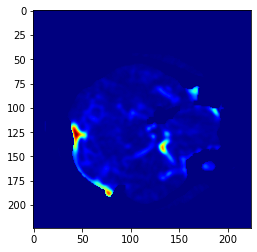

In [9]:
sample_im, sample_seg = im.numpy(), seg.numpy()
plt.imshow(sample_im[0,0,:,:,0],cmap='jet')

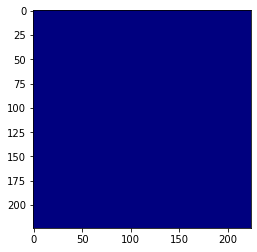

In [10]:
plt.imshow(sample_seg[0,0,:,:,0],cmap='jet')

In [11]:
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

In [12]:
post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold_values=True)])

/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/transforms/post/array.py:182: UserWarning: `threshold_values=True/False` is deprecated, please use `threshold=value` instead.
  warnings.warn("`threshold_values=True/False` is deprecated, please use `threshold=value` instead.")


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [14]:
model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    kernel_size = (3,3),
    #dropout = 0.2,
    num_res_units=2,
).to(device)

In [15]:
model.in_channels

1

In [16]:
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

In [17]:
# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
writer = SummaryWriter()

In [18]:
batch_data = next(iter(loader))
inputs, labels = torch.swapaxes(batch_data[0][0], 1, -1).to(device), torch.swapaxes(batch_data[1][0], 1, -1).to(device).to(device)

In [19]:
print(inputs.shape,labels.shape)

torch.Size([1, 1, 224, 224]) torch.Size([1, 1, 224, 224])


In [20]:
model.train()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit

In [21]:
optimizer.zero_grad()

In [22]:
outputs = model(inputs)

In [23]:
loss = loss_function(outputs, labels)

In [24]:
loss.backward()

In [25]:
optimizer.step()

In [ ]:
for epoch in range(10):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{10}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in loader:
        step += 1
        #inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        #Swaping axes to have a batch of Batch_size, Channels, width and height
        inputs, labels = torch.swapaxes(batch_data[0][0], 1, -1).to(device), torch.swapaxes(batch_data[1][0], 1, -1).to(device).to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(loader) // loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_images = None
            val_labels = None
            val_outputs = None
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                roi_size = (128, 128)
                sw_batch_size = 1
                val_outputs = [sliding_window_inference(val_images[:,:,:,:,i], roi_size, sw_batch_size, model) for i in range(val_images.shape[-1])]
                val_outputs = torch.stack(val_outputs,dim=4)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)
            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model_segmentation2d_array.pth")
                print("saved new best metric model")
            print(
                "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                    epoch + 1, metric, best_metric, best_metric_epoch
                )
            )
            writer.add_scalar("val_mean_dice", metric, epoch + 1)

----------
epoch 1/10
1/94, train_loss: 1.0000
2/94, train_loss: 0.9349
3/94, train_loss: 0.9954
4/94, train_loss: 0.9748
5/94, train_loss: 0.9983
6/94, train_loss: 0.9788
7/94, train_loss: 0.9620
8/94, train_loss: 0.9024
9/94, train_loss: 0.9852
10/94, train_loss: 0.9797
11/94, train_loss: 0.8720
12/94, train_loss: 0.9923
13/94, train_loss: 0.8580
14/94, train_loss: 0.9911
15/94, train_loss: 0.9749
16/94, train_loss: 1.0000
17/94, train_loss: 0.9772
18/94, train_loss: 0.9704
19/94, train_loss: 1.0000
20/94, train_loss: 0.9277
21/94, train_loss: 0.9187
22/94, train_loss: 0.8738
23/94, train_loss: 1.0000
24/94, train_loss: 0.9124
25/94, train_loss: 0.9624
26/94, train_loss: 0.8957
27/94, train_loss: 0.9583
28/94, train_loss: 0.9760
29/94, train_loss: 0.9627
30/94, train_loss: 0.8689
31/94, train_loss: 0.7442
32/94, train_loss: 0.9952
33/94, train_loss: 0.9606
34/94, train_loss: 0.9618
35/94, train_loss: 0.9641
36/94, train_loss: 0.9513
37/94, train_loss: 0.8573
38/94, train_loss: 0.7477

25/94, train_loss: 0.9502
26/94, train_loss: 0.8688
27/94, train_loss: 0.9435
28/94, train_loss: 0.9670
29/94, train_loss: 0.9515
30/94, train_loss: 0.7984
31/94, train_loss: 0.6638
32/94, train_loss: 0.9937
33/94, train_loss: 0.9450
34/94, train_loss: 0.9521
35/94, train_loss: 0.9525
36/94, train_loss: 0.9350
37/94, train_loss: 0.8151
38/94, train_loss: 0.6761
39/94, train_loss: 0.6777
40/94, train_loss: 0.9804
41/94, train_loss: 0.9489
42/94, train_loss: 0.7649
43/94, train_loss: 0.8688
44/94, train_loss: 0.9743
45/94, train_loss: 0.9401
46/94, train_loss: 0.9938
47/94, train_loss: 0.9942
48/94, train_loss: 1.0000
49/94, train_loss: 0.9698
50/94, train_loss: 1.0000
51/94, train_loss: 0.9992
52/94, train_loss: 0.8920
53/94, train_loss: 0.8301
54/94, train_loss: 0.8379
55/94, train_loss: 0.9453
56/94, train_loss: 0.9943
57/94, train_loss: 0.9352
58/94, train_loss: 0.8905
59/94, train_loss: 0.9633
60/94, train_loss: 0.9618
61/94, train_loss: 0.9099
62/94, train_loss: 0.9515
63/94, train

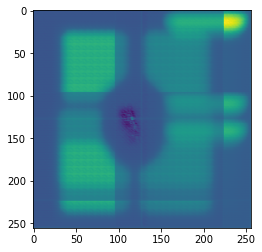

In [95]:
plt.imshow(val_outputs[0,0,:,:,0].detach().numpy())